In [1]:
!pip install mne deap
import mne
from mne.preprocessing import ICA

zsh:1: command not found: pip


In [5]:
!unzip -qq "dataset/BCI_3/subject1_mat.zip" -d dataset/BCI_3/
!unzip -qq "dataset/BCI_3/subject2_mat.zip" -d dataset/BCI_3/
!unzip -qq "dataset/BCI_3/subject3_mat.zip" -d dataset/BCI_3/

## Importar bibliotecas e carregar os dados

In [6]:
import scipy.io
import mne
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados MATLAB de treinamento e teste para o sujeito 1 como exemplo
train_subject1_data = scipy.io.loadmat('dataset/BCI_3/train_subject1_raw01.mat')
test_subject1_data = scipy.io.loadmat('dataset/BCI_3/test_subject1_raw04.mat')

# Visualizar as chaves no dataset MATLAB para entender sua estrutura
print(train_subject1_data.keys())
print(test_subject1_data.keys())

# Extrair os dados brutos de EEG
eeg_data_train = train_subject1_data['X']  # Dados de EEG
eeg_data_test = test_subject1_data['X']  # Dados de EEG de teste

# Extrair os rótulos para os dados de treinamento (se aplicável)
if 'Y' in train_subject1_data:
    labels_train = train_subject1_data['Y']

# Verificar as dimensões dos dados
print("Dimensões dos dados de EEG (Treinamento):", eeg_data_train.shape)
print("Dimensões dos dados de EEG (Teste):", eeg_data_test.shape)

# Verificar se os rótulos estão presentes
if 'Y' in train_subject1_data:
    print("Dimensões dos rótulos (Treinamento):", labels_train.shape)



dict_keys(['__header__', '__version__', '__globals__', 'nfo', 'Y', 'X'])
dict_keys(['__header__', '__version__', '__globals__', 'nfo', 'X'])
Dimensões dos dados de EEG (Treinamento): (122368, 32)
Dimensões dos dados de EEG (Teste): (120832, 32)
Dimensões dos rótulos (Treinamento): (122368, 1)


## Processar e organizar os dados de EEG:

Creating RawArray with float64 data, n_channels=32, n_times=122368
    Range : 0 ... 122367 =      0.000 ...   238.998 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=120832
    Range : 0 ... 120831 =      0.000 ...   235.998 secs
Ready.
Using matplotlib as 2D backend.


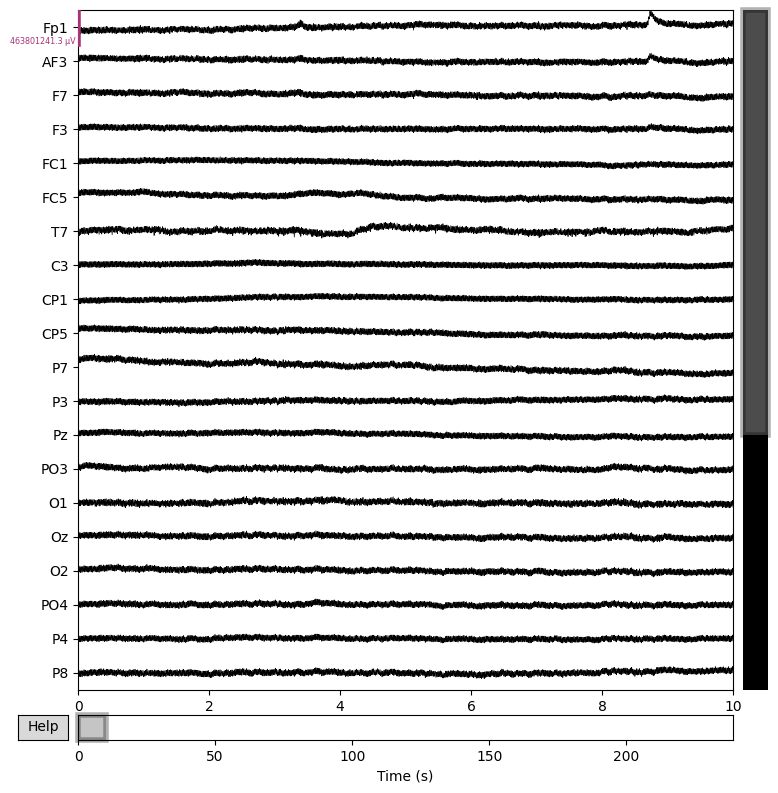

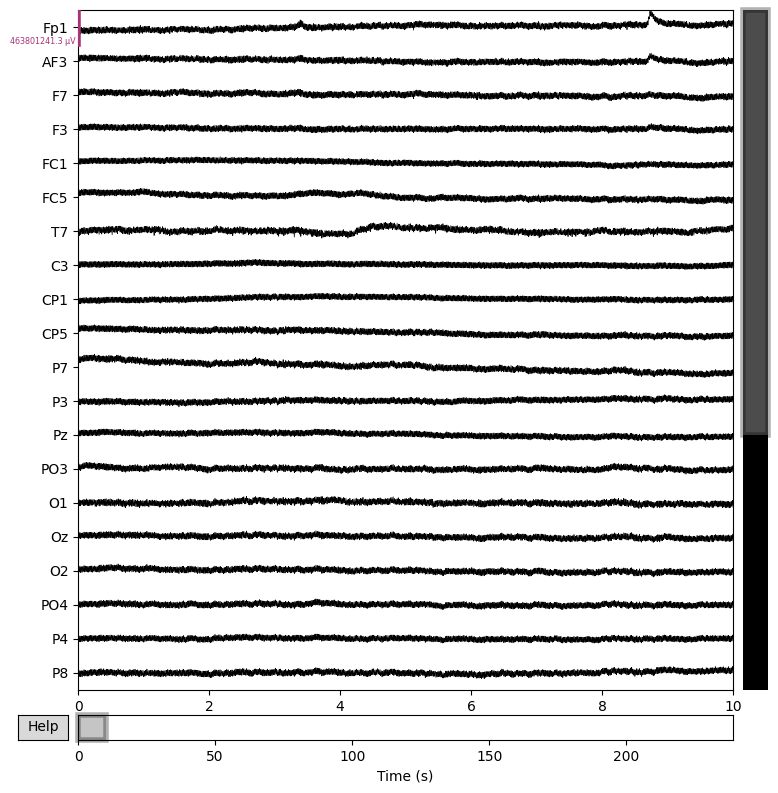

In [7]:
# Definir os nomes dos canais (conforme o dataset)
channel_names = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8',
                 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2',
                 'Fz', 'Cz']

# Definir a taxa de amostragem a partir do dicionário 'nfo', se aplicável
sampling_rate = 512  # Ajuste com base em 'nfo', caso esteja disponível

# Criar a informação do MNE para os canais de EEG
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')

# Criar o objeto RawArray com os dados de EEG
raw_train = mne.io.RawArray(eeg_data_train.T, info)
raw_test = mne.io.RawArray(eeg_data_test.T, info)

# Plotar os sinais brutos de EEG
raw_train.plot(scalings='auto', title='EEG Raw Signals - Treinamento (Sujeito 1)')


## Aplicar filtros nos sinais EEG:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


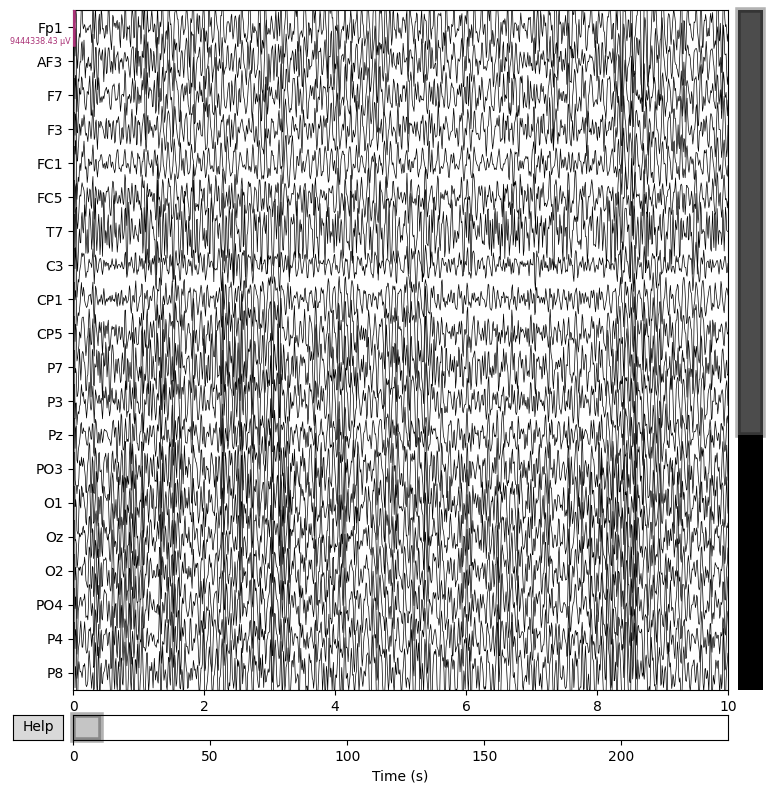

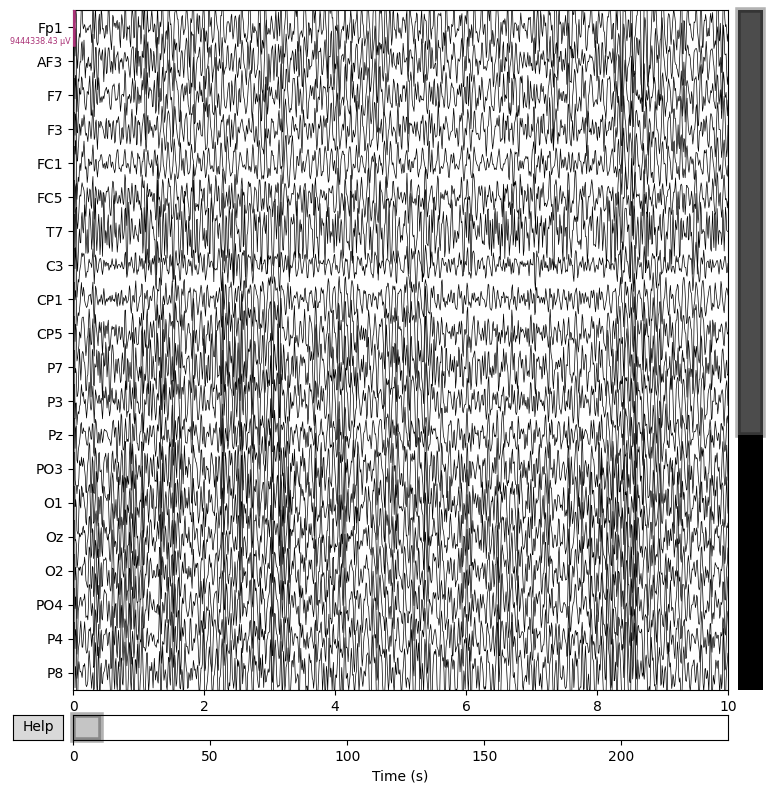

In [8]:
# Aplicar um filtro passa-banda entre 8-30 Hz
raw_filtered_train = raw_train.copy().filter(l_freq=8., h_freq=30., fir_design='firwin')
raw_filtered_test = raw_test.copy().filter(l_freq=8., h_freq=30., fir_design='firwin')

# Plotar os sinais filtrados de EEG
raw_filtered_train.plot(scalings='auto', title='EEG Filtrado (8-30 Hz) - Sujeito 1')

## Visualizar espectrogramas

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


/var/folders/xv/m10cj0cx4ls1q1q7t63fvykr0000gn/T/ipykernel_43987/1876900194.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


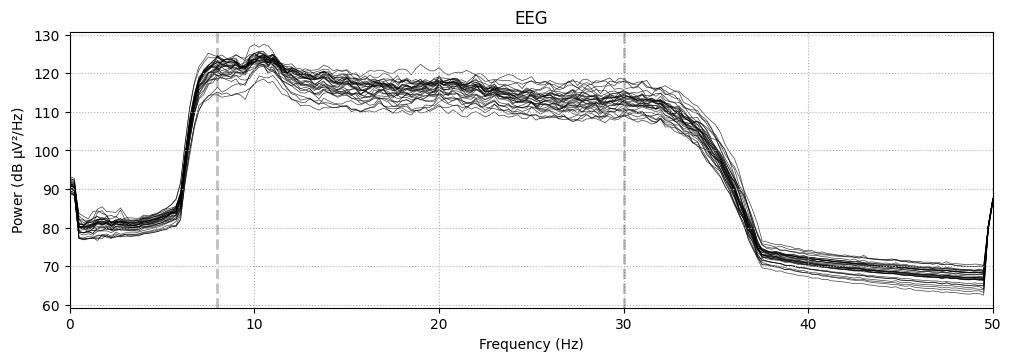

In [9]:
# Compute Power Spectral Density (PSD)
psd = raw_filtered_train.compute_psd(fmax=50, method='welch')

# Plotar o PSD
psd.plot()


## Detecção de Artefatos


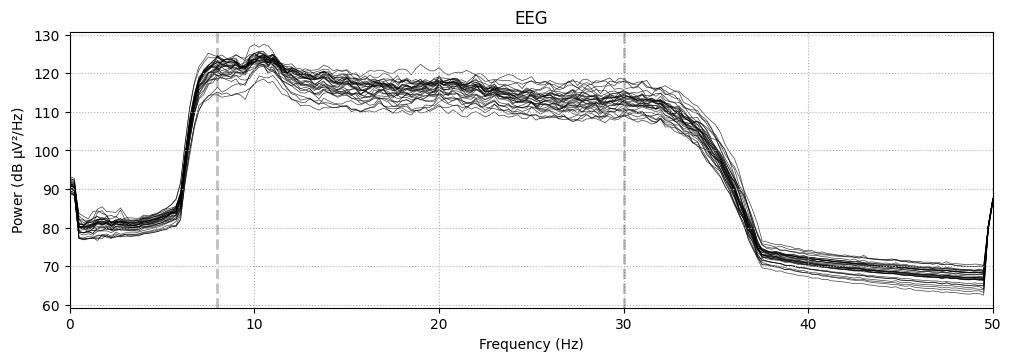

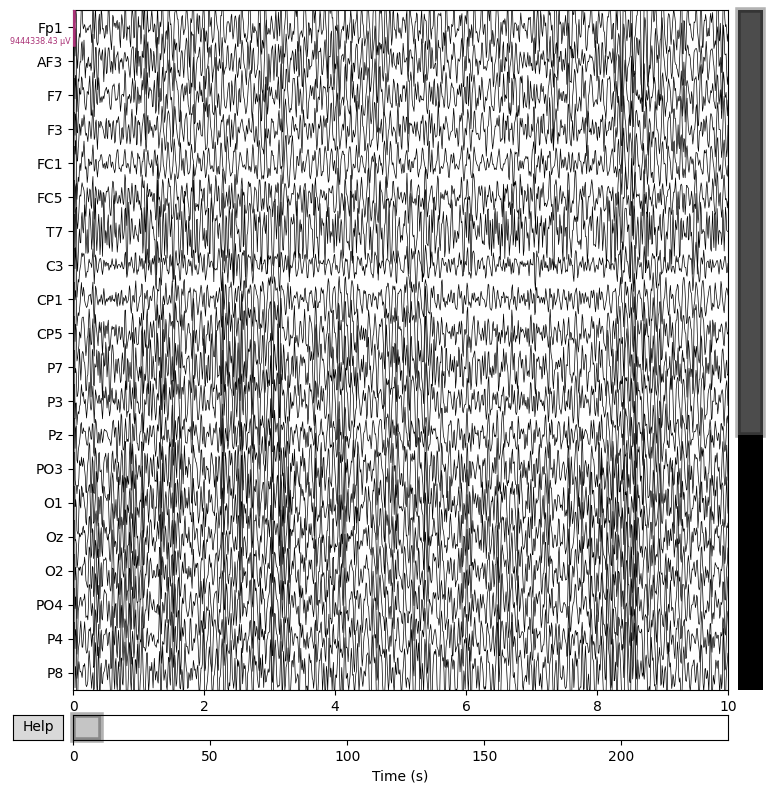

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 339 samples (0.662 s)

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 845 samples (1.650 s)

Filtering raw data in 1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 845 samples (1.650 s)



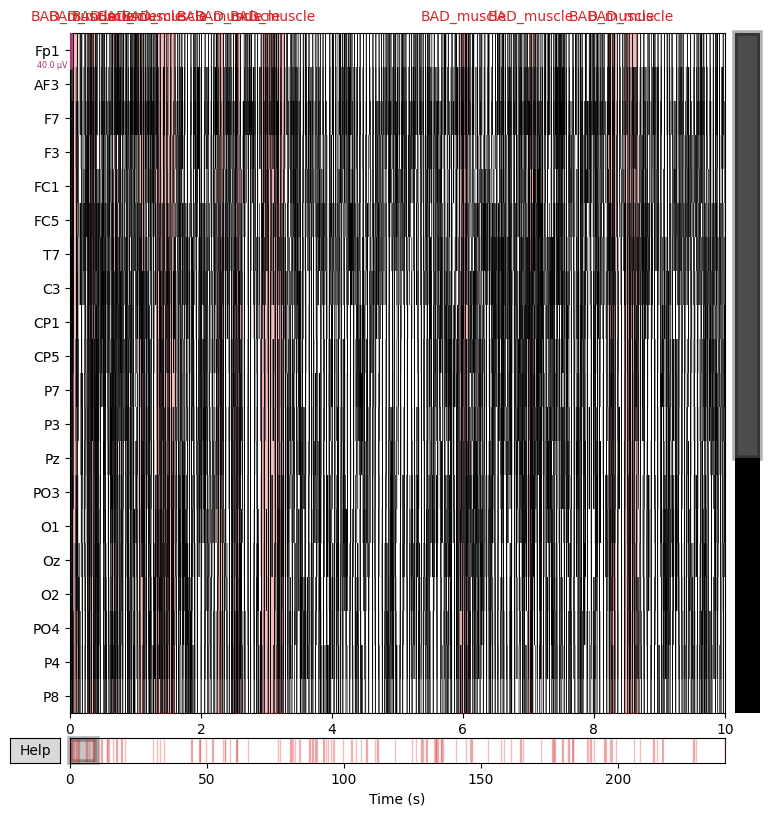

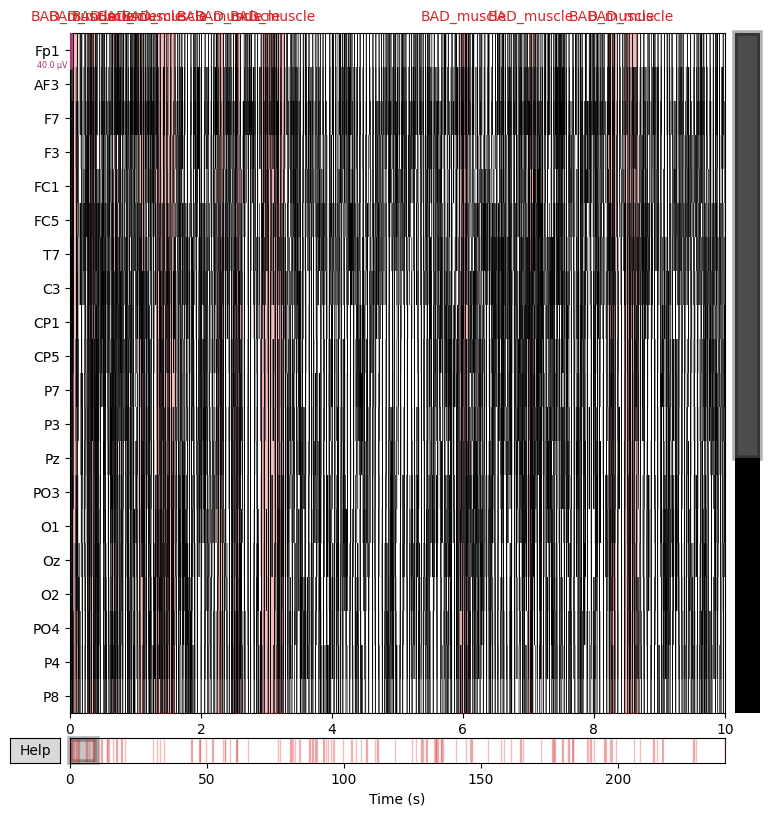

In [10]:
# Detectar artefatos de piscadas e anotar no objeto Raw
raw_filtered_train.plot(block=True, scalings='auto', title='Detecção Manual de Artefatos')

# Detectar artefatos com base na z-score muscular e obter apenas as anotações
annotations_train, scores_train = mne.preprocessing.annotate_muscle_zscore(
    raw_filtered_train, ch_type='eeg', threshold=4.0, min_length_good=0.1, filter_freq=[20, 140]
)

annotations_test, scores_test = mne.preprocessing.annotate_muscle_zscore(
    raw_filtered_test, ch_type='eeg', threshold=4.0, min_length_good=0.1, filter_freq=[20, 140]
)

# Aplicar as anotações no objeto Raw para identificar onde estão os artefatos
raw_filtered_train.set_annotations(annotations_train)
raw_filtered_test.set_annotations(annotations_test)

# Visualizar o EEG novamente para identificar os artefatos detectados
raw_filtered_train.plot()



## Aplicar ICA para Remover Artefatos

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Omitting 5932 of 122368 (4.85%) samples, retaining 116436 (95.15%) samples.
Selecting by number: 20 components
Fitting ICA took 6.7s.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Omitting 7039 of 120832 (5.83%) samples, retaining 113793 (94.17%) samples.
Selecting by number: 20 components
Fitting ICA took 1.8s.
Using EOG channels: Fp1, Fp2
Omitting 5932 of 122368 (4.85%) samples, retaining 116436 (95.15%) samples.
Omitting 5932 of 122368 (4.85%) samples, retaining 116436 (95.15%) samples.
Omitting 5932 of 122368 (4.85%) samples, retaining 116436 (95.15%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Omitting 7039 of 120832 (5.83%) samples, retaining 113793 (94.17%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


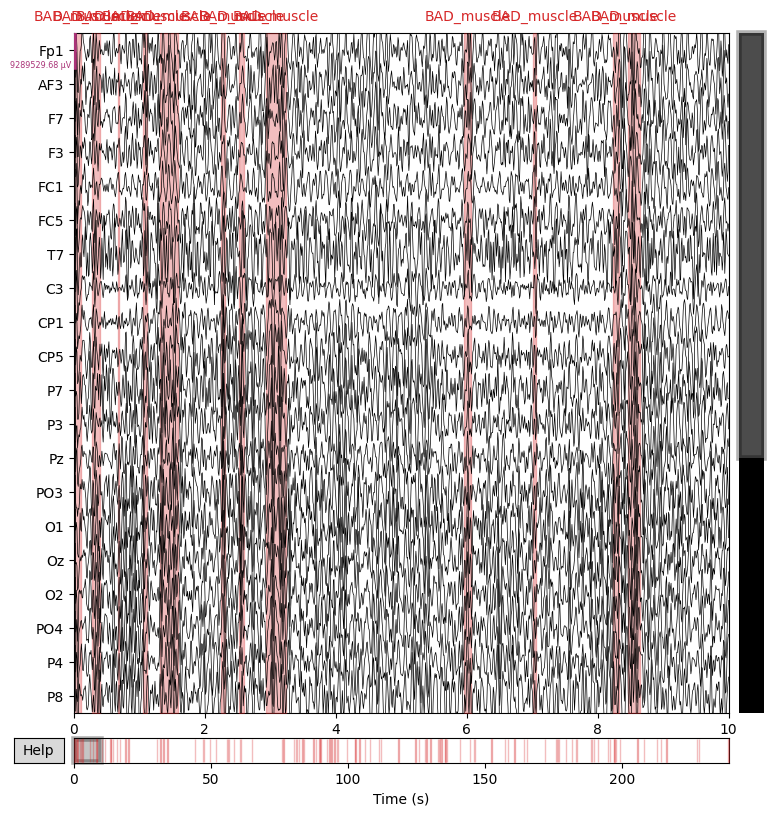

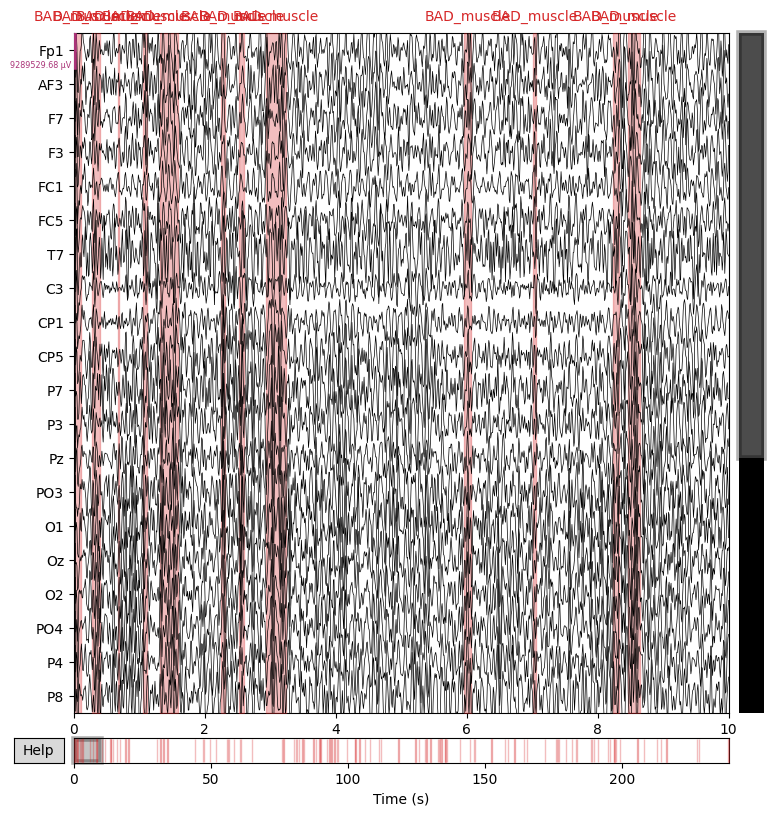

In [11]:
from mne.preprocessing import ICA, create_eog_epochs

# Aplicar ICA para decompor o EEG
ica_train = ICA(n_components=20, random_state=97, max_iter=800)
ica_train.fit(raw_filtered_train)

ica_test = ICA(n_components=20, random_state=97, max_iter=800)
ica_test.fit(raw_filtered_test)

# Detectar automaticamente artefatos relacionados a piscadas (EOG)
eog_indices_train, eog_scores_train = ica_train.find_bads_eog(raw_filtered_train, ch_name=['Fp1', 'Fp2'])  # Canais ao redor dos olhos
eog_indices_test, eog_scores_test = ica_test.find_bads_eog(raw_filtered_test, ch_name=['Fp1', 'Fp2'])  # Canais ao redor dos olhos

# Marcar as componentes a serem excluídas (automático)
ica_train.exclude = eog_indices_train
ica_test.exclude = eog_indices_test

# Aplicar a ICA para remover as componentes de artefatos
raw_train_corrected = raw_filtered_train.copy()
ica_train.apply(raw_train_corrected)
raw_test_corrected = raw_filtered_test.copy()
ica_test.apply(raw_test_corrected)

# Visualizar os sinais corrigidos
raw_train_corrected.plot(scalings='auto', title='EEG Corrigido Automaticamente com ICA')



NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
Setting 5932 of 122368 (4.85%) samples to NaN, retaining 116436 (95.15%) samples.
Effective window size : 4.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 85, using nperseg = 85
  return _func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 143, using nperseg = 143
  return _func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 182, using nperseg = 182
  return _func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 104, using nperseg = 104
  return _func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/time_f

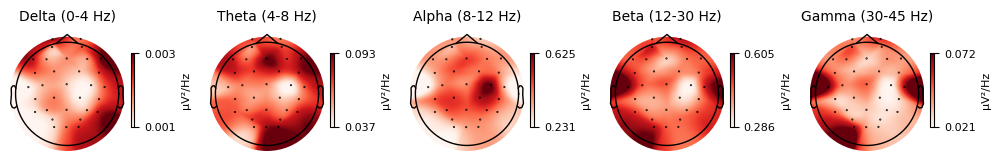

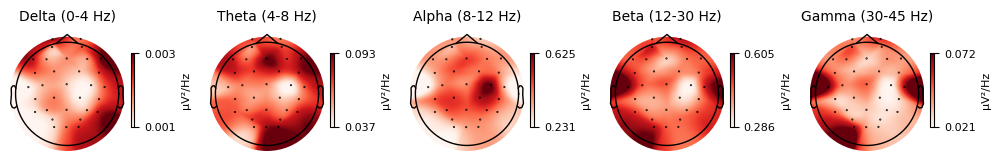

In [12]:
# Adicionar a montagem padrão 10-20 aos dados corrigidos
montage = mne.channels.make_standard_montage('standard_1020')
raw_train_corrected.set_montage(montage)

# Plotar topomapas para diferentes frequências de interesse
raw_train_corrected.plot_psd_topomap(ch_type='eeg', normalize=True)


## Exportar os dados tratados

In [13]:
import pandas as pd

# Extrair os dados do objeto RawArray corrigido
eeg_data_corrected = raw_train_corrected.get_data()

# Obter os nomes dos canais
channel_names = raw_train_corrected.info['ch_names']

# Criar um DataFrame com os dados e os nomes dos canais
df_eeg = pd.DataFrame(eeg_data_corrected.T, columns=channel_names)

# Adicionar a coluna de tempo (índice de tempo)
df_eeg['time'] = raw_train_corrected.times

# Adicionar a coluna 'patient' com valor fixo '1'
df_eeg['patient'] = 1

# Adicionar a coluna 'label' com os rótulos (substitua 'labels_train' pelos rótulos corretos)
if 'Y' in train_subject1_data:
    labels_train = train_subject1_data['Y'].flatten()  # Caso os rótulos estejam disponíveis
    df_eeg['label'] = pd.Series(labels_train[:df_eeg.shape[0]])  # Atribuir rótulos aos dados
else:
    df_eeg['label'] = None  # Se os rótulos não estiverem disponíveis

# Criar a coluna 'epoch' (número de época) com base na janela de tempo
df_eeg['epoch'] = (df_eeg.index // (sampling_rate * 2)).astype(int)  # Definir épocas com base em intervalos de 2 segundos

# Reordenar as colunas para colocar 'patient', 'time', 'label' e 'epoch' nas primeiras colunas
columns_order = ['patient', 'time', 'label', 'epoch'] + channel_names
df_eeg = df_eeg[columns_order]

# Exportar o DataFrame para um arquivo CSV com o nome desejado
df_eeg.to_csv('bci_competition_3_v.csv', index=False)

print("Dados exportados para 'bci_competition_3_v.csv'")


Dados exportados para 'bci_competition_3_v.csv'


In [14]:
# Extrair os dados do objeto RawArray corrigido (dados de teste)
eeg_data_test_corrected = raw_test_corrected.get_data()

# Obter os nomes dos canais
channel_names_test = raw_test_corrected.info['ch_names']

# Criar um DataFrame com os dados e os nomes dos canais
df_eeg_test = pd.DataFrame(eeg_data_test_corrected.T, columns=channel_names_test)

# Adicionar a coluna de tempo (índice de tempo)
df_eeg_test['time'] = raw_test_corrected.times

# Adicionar a coluna 'patient' com valor fixo '1'
df_eeg_test['patient'] = 1

# Adicionar a coluna 'label' com None (já que os dados de teste não têm rótulos)
df_eeg_test['label'] = None

# Criar a coluna 'epoch' (número de época) com base na janela de tempo
df_eeg_test['epoch'] = (df_eeg_test.index // (sampling_rate * 2)).astype(int)  # Definir épocas com base em intervalos de 2 segundos

# Reordenar as colunas para colocar 'patient', 'time', 'label' e 'epoch' nas primeiras colunas
columns_order_test = ['patient', 'time', 'label', 'epoch'] + channel_names_test
df_eeg_test = df_eeg_test[columns_order_test]

# Exportar o DataFrame para um arquivo CSV com o nome desejado
df_eeg_test.to_csv('bci_competition_3_v_test.csv', index=False)

print("Dados de teste exportados para 'bci_competition_3_v_test.csv'")


Dados de teste exportados para 'bci_competition_3_v_test.csv'


## Modelos de Classificação

### KNN

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Carregar os dados tratados (de treinamento)
df_train = pd.read_csv('bci_competition_3_v.csv')

# 2. Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# 3. Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Definir o classificador KNN
knn = KNeighborsClassifier()

# 6. Definir a grade de hiperparâmetros para o GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['distance'],
    'metric': ['euclidean']
}

# 7. Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True  # Opcional: inclui as pontuações de treinamento
)

# 8. Treinar o modelo usando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# 9. Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:")
print(best_params)

# 10. Avaliar o modelo com os melhores hiperparâmetros no conjunto de teste
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# 11. Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia com os melhores hiperparâmetros: {accuracy:.4f}")

# Relatório de classificação detalhado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# 12. Imprimir a acurácia de cada combinação de hiperparâmetros
results = pd.DataFrame(grid_search.cv_results_)

# Selecionar colunas relevantes
results = results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Ordenar os resultados pelo rank
results = results.sort_values('rank_test_score')

print("\nResultados de todas as combinações de hiperparâmetros:")
print(results.to_string(index=False))


Melhores hiperparâmetros encontrados:
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Acurácia com os melhores hiperparâmetros: 0.9680

Relatório de Classificação:
              precision    recall  f1-score   support

           2       0.96      0.97      0.96      6426
           3       0.96      0.97      0.97      7926
           7       0.98      0.97      0.97     10122

    accuracy                           0.97     24474
   macro avg       0.97      0.97      0.97     24474
weighted avg       0.97      0.97      0.97     24474


Resultados de todas as combinações de hiperparâmetros:
                                                           params  mean_test_score  std_test_score  rank_test_score
 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}         0.935941        0.001945                1
 {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}         0.918177        0.001409                2
 {'metric': 'euclidean', 'n_neigh

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# 1. Carregar os dados tratados (de treinamento)
df_train = pd.read_csv('bci_competition_3_v.csv')

# 2. Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# 3. Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 4. Definir o pipeline com scaler, PCA e KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# 5. Definir a grade de hiperparâmetros para o GridSearchCV
param_grid = {
    'pca__n_components': [0.95, 0.99, 0.9, 0.8],  # Mantém 95%, 99%, 90%, 80% da variância
    'knn__n_neighbors': [1, 3, 5, 7, 9],
    'knn__weights': ['distance'],
    'knn__metric': ['euclidean']
}

# 6. Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

# 7. Treinar o modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# 8. Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:")
print(best_params)

# 9. Avaliar o modelo com os melhores hiperparâmetros no conjunto de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 10. Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia com os melhores hiperparâmetros: {accuracy:.4f}")

# Relatório de classificação detalhado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# 11. Imprimir a acurácia de cada combinação de hiperparâmetros
results = pd.DataFrame(grid_search.cv_results_)

# Selecionar colunas relevantes
results = results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Ordenar os resultados pelo rank
results = results.sort_values('rank_test_score')

print("\nResultados de todas as combinações de hiperparâmetros:")
print(results.to_string(index=False))


Melhores hiperparâmetros encontrados:
{'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'knn__weights': 'distance', 'pca__n_components': 0.99}

Acurácia com os melhores hiperparâmetros: 0.9890

Relatório de Classificação:
              precision    recall  f1-score   support

           2       0.98      0.99      0.99      6426
           3       0.99      0.99      0.99      7926
           7       0.99      0.99      0.99     10122

    accuracy                           0.99     24474
   macro avg       0.99      0.99      0.99     24474
weighted avg       0.99      0.99      0.99     24474


Resultados de todas as combinações de hiperparâmetros:
                                                                                                    params  mean_test_score  std_test_score  rank_test_score
{'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'knn__weights': 'distance', 'pca__n_components': 0.99}         0.970202        0.001114                1
{'knn__metric': 'euclidea

### SVM

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# 1. Carregar os dados tratados (de treinamento)
df_train = pd.read_csv('bci_competition_3_v.csv')

# 2. Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# 3. Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Reduzir a dimensionalidade com PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 6. Treinar o classificador SVM com parâmetros ajustados
param_grid_svm = {'C': [10], 'kernel': ['linear']}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=2, n_jobs=-1)
grid_svm.fit(X_train_pca, y_train)
svm_model = grid_svm.best_estimator_

# 7. Fazer previsões nos dados de teste
y_pred = svm_model.predict(X_test_pca)

# 8. Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

### DNN

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# 1. Carregar os dados tratados (de treinamento)
df_train = pd.read_csv('bci_competition_3_v.csv')

# 2. Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# Mapear os rótulos para índices sequenciais
unique_labels = sorted(y.unique())  # [1, 2, 3, 7]
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for idx, label in enumerate(unique_labels)}
y_mapped = y.map(label_to_index)

# 3. Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

# 4. Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Reduzir a dimensionalidade com PCA
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Converter para float32
X_train_pca = X_train_pca.astype('float32')
X_test_pca = X_test_pca.astype('float32')

# Converter y_train e y_test para arrays NumPy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# 6. Treinar o classificador DNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir a arquitetura da rede neural
input_dim = X_train_pca.shape[1]  # Número de features após o PCA

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=input_dim))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation='softmax'))  # Usando 'softmax' para classificação multiclasse

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train_pca, y_train, epochs=100, batch_size=32, validation_split=0.2)

# 7. Fazer previsões nos dados de teste
y_pred_probs = model.predict(X_test_pca)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_pred = np.array([index_to_label[idx] for idx in y_pred_indices])

# 8. Avaliar o modelo
y_test_labels = np.array([index_to_label[idx] for idx in y_test])
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Acurácia: {accuracy:.4f}")

print("Relatório de Classificação:")
print(classification_report(y_test_labels, y_pred))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: object __array__ method not producing an array

## Seleção de canais (com AG)

### 16-16

In [1]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Carregar os dados
df_train = pd.read_csv('bci_competition_3_v.csv')

# Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configuração do Algoritmo Genético

# Criação da classe de fitness (maior acurácia é melhor)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Função para criar um indivíduo (vetor binário representando os canais)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(X_train.shape[1])]
    # Garantir que o indivíduo selecione exatamente 16 canais
    while sum(individual) != 16:
        individual = [random.randint(0, 1) for _ in range(X_train.shape[1])]
    return creator.Individual(individual)

# Função de fitness que avalia a acurácia do KNN com os canais selecionados
def evaluate(individual):
    selected_channels = [i for i, bit in enumerate(individual) if bit == 1]

    # Se nenhum canal for selecionado, penalizar o fitness
    if len(selected_channels) != 16:
        return 0,

    # Treinar o KNN com os canais selecionados
    X_train_selected = X_train_scaled[:, selected_channels]
    X_test_selected = X_test_scaled[:, selected_channels]

    # Com KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_selected, y_train)
    y_pred = knn.predict(X_test_selected)

    # Com SVM
    # svm = SVC(kernel='linear')
    # svm.fit(X_train_selected, y_train)
    # y_pred = svm.predict(X_test_selected)

    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy,

# Função para mutar um indivíduo (trocar o valor de 0 para 1 ou 1 para 0 aleatoriamente)
def mutate(individual):
    # Aplicar mutação garantindo que sempre haja 16 canais selecionados
    index = random.randrange(len(individual))
    individual[index] = 1 - individual[index]  # Troca 0 por 1 ou 1 por 0

    # Garantir que o número de canais selecionados continue sendo 16
    while sum(individual) != 16:
        index = random.randrange(len(individual))
        individual[index] = 1 - individual[index]

    return individual,

# Função de crossover (combinar partes de dois indivíduos)
def crossover(ind1, ind2):
    cxpoint = random.randint(1, len(ind1) - 1)
    ind1[cxpoint:], ind2[cxpoint:] = ind2[cxpoint:], ind1[cxpoint:]

    # Garantir que ambos os indivíduos resultantes tenham 16 canais selecionados
    while sum(ind1) != 16:
        index = random.randrange(len(ind1))
        ind1[index] = 1 - ind1[index]

    while sum(ind2) != 16:
        index = random.randrange(len(ind2))
        ind2[index] = 1 - ind2[index]

    return ind1, ind2

# Função de seleção (torneio)
toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parâmetros do Algoritmo Genético
population_size = 50
num_generations = 2
mutation_prob = 0.2
crossover_prob = 0.5

# Criar a população inicial
population = toolbox.population(n=population_size)

# Rodar o algoritmo genético
algorithms.eaSimple(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=num_generations, verbose=True)

# Obter o melhor indivíduo
best_individual = tools.selBest(population, k=1)[0]
best_16_accuracy = evaluate(best_individual)[0]
selected_16_channels = [i for i, bit in enumerate(best_individual) if bit == 1]

print(f"Melhor Acurácia: {best_16_accuracy}")
print(f"16 Canais Selecionados: {selected_16_channels}")


gen	nevals
0  	50    
1  	29    
2  	27    
Melhor Acurácia: 0.853150281931846
16 Canais Selecionados: [1, 2, 3, 6, 7, 8, 11, 12, 13, 22, 23, 24, 26, 29, 30, 31]


### 8 -24

In [ ]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Carregar os dados
df_train = pd.read_csv('bci_competition_3_v.csv')

# Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configuração do Algoritmo Genético

# Criação da classe de fitness (maior acurácia é melhor)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Função para criar um indivíduo (vetor binário representando os canais)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(X_train.shape[1])]
    # Garantir que o indivíduo selecione exatamente 8 canais
    while sum(individual) != 8:
        individual = [random.randint(0, 1) for _ in range(X_train.shape[1])]
    return creator.Individual(individual)

# Função de fitness que avalia a acurácia do KNN com os canais selecionados
def evaluate(individual):
    selected_channels = [i for i, bit in enumerate(individual) if bit == 1]

    # Se nenhum canal for selecionado, penalizar o fitness
    if len(selected_channels) != 8:
        return 0,

    # Treinar o KNN com os canais selecionados
    X_train_selected = X_train_scaled[:, selected_channels]
    X_test_selected = X_test_scaled[:, selected_channels]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_selected, y_train)
    y_pred = knn.predict(X_test_selected)

    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy,

# Função para mutar um indivíduo (trocar o valor de 0 para 1 ou 1 para 0 aleatoriamente)
def mutate(individual):
    # Aplicar mutação garantindo que sempre haja 8 canais selecionados
    index = random.randrange(len(individual))
    individual[index] = 1 - individual[index]  # Troca 0 por 1 ou 1 por 0

    # Garantir que o número de canais selecionados continue sendo 8
    while sum(individual) != 8:
        index = random.randrange(len(individual))
        individual[index] = 1 - individual[index]

    return individual,

# Função de crossover (combinar partes de dois indivíduos)
def crossover(ind1, ind2):
    cxpoint = random.randint(1, len(ind1) - 1)
    ind1[cxpoint:], ind2[cxpoint:] = ind2[cxpoint:], ind1[cxpoint:]

    # Garantir que ambos os indivíduos resultantes tenham 8 canais selecionados
    while sum(ind1) != 8:
        index = random.randrange(len(ind1))
        ind1[index] = 1 - ind1[index]

    while sum(ind2) != 8:
        index = random.randrange(len(ind2))
        ind2[index] = 1 - ind2[index]

    return ind1, ind2

# Função de seleção (torneio)
toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parâmetros do Algoritmo Genético
population_size = 50
num_generations = 2
mutation_prob = 0.2
crossover_prob = 0.5

# Criar a população inicial
population = toolbox.population(n=population_size)

# Rodar o algoritmo genético
algorithms.eaSimple(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=num_generations, verbose=True)

# Obter o melhor indivíduo
best_individual = tools.selBest(population, k=1)[0]
best_8_accuracy = evaluate(best_individual)[0]
selected_8_channels = [i for i, bit in enumerate(best_individual) if bit == 1]

print(f"Melhor Acurácia: {best_8_accuracy}")
print(f"8 Canais Selecionados: {selected_8_channels}")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	33    
2  	29    
Melhor Acurácia: 0.7053199313557245
8 Canais Selecionados: [4, 8, 12, 14, 19, 22, 23, 31]


## GANs

In [25]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Concatenate  # Adicionar Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# Carregar os dados
df_train = pd.read_csv('bci_competition_3_v.csv')

# Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Separar os 16 canais recomendados pelo Algoritmo Genético
X_train_selected = X_train_scaled[:, selected_16_channels]
X_test_selected = X_test_scaled[:, selected_16_channels]

# Treinamento da GAN para gerar os 16 canais artificiais

# Função para construir o gerador (gera 16 canais artificiais)
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=16))  # Corrigir input_dim para 16 canais
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(16, activation='tanh'))  # Gera 16 canais artificiais
    return model

# Função para construir o discriminador (recebe 32 canais: 16 reais + 16 gerados)
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=32))  # 32 canais totais
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Saída binária (real ou falso)
    return model

# Função para compilar a GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Congela o discriminador

    # Entrada dos 16 canais reais
    real_input = Input(shape=(16,))

    # Entrada para os 16 canais gerados
    noise_input = Input(shape=(16,))
    gen_channels = generator(noise_input)  # Gerar 16 canais artificiais

    # Combinar os 16 canais reais com os 16 canais gerados
    combined_input = Concatenate()([real_input, gen_channels])

    # Passar os 32 canais (reais + gerados) para o discriminador
    validity = discriminator(combined_input)

    return Model([real_input, noise_input], validity)

# Compilação da GAN
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

# Função para treinar a GAN
def train_gan(epochs, batch_size, X_train_selected):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Treinar o discriminador
        idx = np.random.randint(0, X_train_selected.shape[0], half_batch)
        real_channels = X_train_selected[idx]
        noise = np.random.normal(0, 1, (half_batch, 16))

        gen_channels = generator.predict(noise)

        combined_channels = np.concatenate((real_channels, gen_channels), axis=1)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(combined_channels, real_labels)
        d_loss_fake = discriminator.train_on_batch(combined_channels, fake_labels)

        noise = np.random.normal(0, 1, (batch_size, 16))
        real_channels_for_gan = X_train_selected[np.random.randint(0, X_train_selected.shape[0], batch_size)]
        g_loss = gan.train_on_batch([real_channels_for_gan, noise], np.ones((batch_size, 1)))

        print(f"Epoch {epoch}/{epochs} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]")

# Exemplo de treino da GAN (assumindo que X_train_selected tenha sido previamente definido)
train_gan(epochs=1000, batch_size=32, X_train_selected=X_train_selected)

# Gerar canais artificiais para o conjunto de teste
noise = np.random.normal(0, 1, (X_test_selected.shape[0], 16))
generated_channels_test = generator.predict(noise)

# Combinar os 16 canais reais com os 16 artificiais
X_test_combined = np.concatenate((X_test_selected, generated_channels_test), axis=1)

# Treinar e avaliar o classificador KNN com os 16 canais reais + 16 artificiais
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(np.concatenate((X_train_selected, np.random.normal(0, 1, (X_train_selected.shape[0], 16))), axis=1), y_train)  # Gerar aleatoriamente canais artificiais para treino
y_pred = knn.predict(X_test_combined)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia com canais reais + artificiais: {accuracy:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: object __array__ method not producing an array

### Modelo de Difusão

In [24]:
# selected_16_channels = [0, 1, 3, 5, 6, 7, 8, 10, 15, 22, 23, 26, 28, 29, 30, 31]
selected_16_channels = [2, 3, 4, 6, 7, 8, 10, 12, 13, 17, 20, 22, 23, 27, 28, 30]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Carregar os dados (como no caso dos GANs)
df_train = pd.read_csv('bci_competition_3_v.csv')

# Separar features (X) e rótulos (y)
X = df_train.drop(columns=['patient', 'time', 'label', 'epoch'])
y = df_train['label'].dropna().astype(int)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Supondo que você tenha definido 'selected_16_channels' anteriormente
# Exemplo: selected_16_channels = [0, 1, 2, ..., 15]
selected_16_channels = np.arange(16)  # Substitua isso pela sua seleção real

# Separar os 16 canais recomendados pelo Algoritmo Genético
X_train_selected = X_train_scaled[:, selected_16_channels]
X_test_selected = X_test_scaled[:, selected_16_channels]

# Definir o modelo de difusão
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x, t):
        return self.model(x)

# Função de difusão corrigida (adiciona ruído gradual aos dados)
def forward_diffusion(x, t, beta_t):
    noise = torch.randn_like(x)
    beta_t = beta_t.view(-1, 1).expand_as(x)  # Expande para o número de amostras (batch) e canais
    return torch.sqrt(1 - beta_t) * x + torch.sqrt(beta_t) * noise

# Função de perda
def loss_fn(model, x, t, beta_t):
    noise = torch.randn_like(x)
    x_noisy = forward_diffusion(x, t, beta_t)
    predicted_noise = model(x_noisy, t)
    return nn.functional.mse_loss(predicted_noise, noise)

# Parâmetros de difusão
T = 300  # Número de passos de difusão
beta = np.linspace(0.0001, 0.02, T)  # Taxa de difusão variando ao longo do tempo

# Função para treinar o modelo de difusão
def train_diffusion_model(model, data, epochs=50, batch_size=32, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(data), batch_size):
            batch = torch.tensor(data[i:i + batch_size], dtype=torch.float32)
            current_batch_size = batch.shape[0]  # Tamanho atual do batch
            t = torch.randint(0, T, (current_batch_size,))
            beta_t = torch.tensor(beta[t], dtype=torch.float32)

            optimizer.zero_grad()
            loss = loss_fn(model, batch, t, beta_t)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss / len(data)}")

# Gerar novos dados utilizando o modelo treinado
def generate_samples(model, num_samples, input_dim):
    samples = torch.randn(num_samples, input_dim)
    for t in reversed(range(T)):
        beta_t = torch.tensor(beta[t])
        noise = torch.randn_like(samples) if t > 0 else 0
        samples = (samples - beta_t * model(samples, t)) / torch.sqrt(1 - beta_t)
        samples += torch.sqrt(beta_t) * noise
    return samples.detach().numpy()

# Inicializar o modelo de difusão e treinar
input_dim = X_train_selected.shape[1]
diffusion_model = DiffusionModel(input_dim)
train_diffusion_model(diffusion_model, X_train_selected)

# Gerar novos canais artificiais
generated_channels_test = generate_samples(diffusion_model, num_samples=X_test_selected.shape[0], input_dim=input_dim)

# Combinar os 16 canais reais com os 16 artificiais
X_test_combined = np.concatenate((X_test_selected, generated_channels_test), axis=1)

# Treinar e avaliar o classificador KNN com os 16 canais reais + 16 artificiais
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
X_train_combined = np.concatenate((X_train_selected, generate_samples(diffusion_model, num_samples=X_train_selected.shape[0], input_dim=input_dim)), axis=1)
knn.fit(X_train_combined, y_train)

# Fazer previsões nos dados de teste e calcular a acurácia
y_pred = knn.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"Acurácia com canais reais + artificiais gerados por Modelo de Difusão: {accuracy:.4f}")


Epoch 1/50 - Loss: 0.03123319525602955
Epoch 2/50 - Loss: 0.03128678447796375
Epoch 3/50 - Loss: 0.031314171792990945
Epoch 4/50 - Loss: 0.031268592345682175
Epoch 5/50 - Loss: 0.0312756846463115
Epoch 6/50 - Loss: 0.03125317759172109
Epoch 7/50 - Loss: 0.031229266420137354
Epoch 8/50 - Loss: 0.031232767732408333
Epoch 9/50 - Loss: 0.031212604108946773
Epoch 10/50 - Loss: 0.03125319134851256
Epoch 11/50 - Loss: 0.03125802954521832
Epoch 12/50 - Loss: 0.031226305061627095
Epoch 13/50 - Loss: 0.03126081193818582
Epoch 14/50 - Loss: 0.03120471119215791
Epoch 15/50 - Loss: 0.03127501354516216
Epoch 16/50 - Loss: 0.031275936365639016
Epoch 17/50 - Loss: 0.031233791072324733
Epoch 18/50 - Loss: 0.03125194758453839
Epoch 19/50 - Loss: 0.03131532048446973
Epoch 20/50 - Loss: 0.03122366845204686
Epoch 21/50 - Loss: 0.03122569119114139
Epoch 22/50 - Loss: 0.031183202133910914
Epoch 23/50 - Loss: 0.03128205919179531
Epoch 24/50 - Loss: 0.031242356156392963
Epoch 25/50 - Loss: 0.03122829587283674
